In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import swiftestio as swio
from astroquery.jplhorizons import Horizons

In [5]:
inparfile = 'param.swifter.in'
paramgr = swio.read_swifter_param(inparfile)
swifterdat = swio.swifter2xr(paramgr)

Reading Swifter file param.swifter.in


In [6]:
param_file_name = 'param.swiftest.in'
config = swio.read_swiftest_config(param_file_name)
swiftestdat = swio.swiftest2xr(config)

Reading Swiftest file param.swiftest.in


In [7]:
swifterdat['varpi'] = swifterdat['omega'] + swifterdat['capom']
swiftestdat['varpi'] = swiftestdat['omega'] + swiftestdat['capom']

In [32]:
obj = Horizons(id='1', id_type='majorbody',location='@sun',
               epochs={'start':'2021-01-28', 'stop':'3021-02-05',
                       'step':'1y'})
el = obj.elements()
t = (el['datetime_jd']-el['datetime_jd'][0]) / 365.25
varpi_obs = el['w'] + el['Omega']

In [33]:
varpiswiftest = swiftestdat['varpi'].sel(id=2) * 180.0 / np.pi
varpiswifter = swifterdat['varpi'].sel(id=2) * 180.0 / np.pi
tsim = swiftestdat['time']

In [39]:
dvarpi_swiftest = np.diff(varpiswiftest)  * 3600 * 100 
dvarpi_swifter = np.diff(varpiswifter)  * 3600 * 100 
dvarpi_obs = np.diff(varpi) / np.diff(t) * 3600 * 100 

Mean precession rate for Mercury long. peri. (arcsec/100 y)
JPL Horizons      : 571.3219335838123
Swifter GR        : 571.1981012667945
Swiftest GR       : 571.1981012549461
Obs - Swifter     : 0.12383231701787104
Obs - Swiftest    : 0.12383232886631326
Swiftest - Swifter: -1.1848442227346823e-08


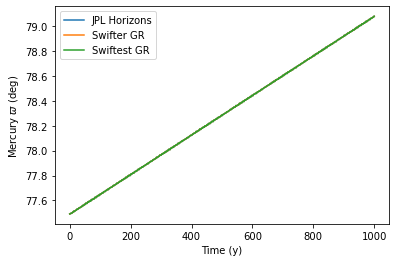

In [40]:
fig, ax = plt.subplots()

ax.plot(t, varpi_obs, label="JPL Horizons")
ax.plot(tsim, varpiswifter, label="Swifter GR")
ax.plot(tsim, varpiswiftest, label="Swiftest GR")
ax.set_xlabel('Time (y)')
ax.set_ylabel('Mercury $\\varpi$ (deg)')
ax.legend()
print('Mean precession rate for Mercury long. peri. (arcsec/100 y)')
print(f'JPL Horizons      : {np.mean(dvarpi_obs)}')
print(f'Swifter GR        : {np.mean(dvarpi_swifter)}')
print(f'Swiftest GR       : {np.mean(dvarpi_swiftest)}')
print(f'Obs - Swifter     : {np.mean(dvarpi_obs - dvarpi_swifter)}')
print(f'Obs - Swiftest    : {np.mean(dvarpi_obs - dvarpi_swiftest)}')
print(f'Swiftest - Swifter: {np.mean(dvarpi_swiftest - dvarpi_swifter)}')